# Structure of Henbun

This notebook describes structure of Henbun and how to construct a model with it.  
We construct a linear model as an example.

Note that *Henbun* is not very effective for such a very simple model.  
This example is just to present Henbun's structure and its main functionalities.

# Import libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import Henbun as hb

# Toy data

In [2]:
X = np.linspace(0,6,40).reshape(-1,1)
Y = 0.5*X + np.random.randn(40,1)*0.3 + 0.4

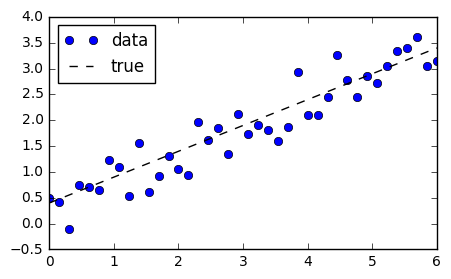

In [3]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, 0.5*X+0.4, '--k', label='true')
plt.legend(loc='best')

# Linear Fit Model

We assume the data $y_i$ has a linear relation with input $x_i$.
 
$$y_i \sim a + b x_i$$

with coefficients a and b.

We seek $a$ and $b$ that minimizes the following loss
$$
\mathrm{Loss} = \sum_i{(y_i - (a + b * x_i))^2}
$$

## Construct a linear fit model

In [4]:
class LinearFit(hb.model.Model):
    def setUp(self):
        """
        This method is called just after the instanciation of this class.
        In this method, we need to define any variables and data to be used in this model.
        """
        # data should be stored in hb.param.Data class
        self.X = hb.param.Data(X)
        self.Y = hb.param.Data(Y)
        
        # Parameters that are defined as hb.param.Variable will be optimized by this model.
        self.a = hb.param.Variable(shape=[1])
        self.b = hb.param.Variable(shape=[1])
        
    @hb.model.AutoOptimize()
    def MinusLoss(self):
        """
        Any method decorated by @AutoOptimize can be optimized.
        Here we return the minus of Loss
        """
        return -tf.reduce_sum(tf.square(self.Y - (self.a + self.b * self.X)))

In [5]:
linear_fit = LinearFit()

## See what is inside in Variables

The Variables are automatically initialized.  
To see what values are inside this object, *.value* property can be used **after** the initialization. 

In [6]:
# To initialize values call .initialize()
linear_fit.initialize()

In [7]:
print(linear_fit.a.value, linear_fit.b.value)

[-1.67150223] [ 0.44493127]


In [8]:
# Manually initialize variables
# To initialize manually, just set the desired value,
linear_fit.a = 0.1
linear_fit.b = 0.1
# To reflect this operation, another `initialize` call is necessary
linear_fit.initialize()

In [9]:
# see the values were updated.
print(linear_fit.a.value, linear_fit.b.value)

[ 0.1] [ 0.1]


## Find parameters $a$ and $b$ that minimizes the Loss

### Compilation and optimization

To make an optimization, we need to *compile* the objective.

In our case, the objective is linear_fit.MinusLoss.

In [10]:
# compilation
linear_fit.MinusLoss().compile()

compiling...


In [11]:
# optimization can be made after .compile() method is completed.
linear_fit.MinusLoss().optimize(maxiter=10000)

## See the results

The values in Variable object is updated by *optimize* method.

In [12]:
print(linear_fit.a.value, linear_fit.b.value)

[ 0.28245133] [ 0.51669943]


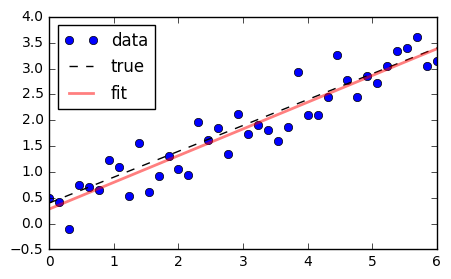

In [13]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, 0.5*X+0.4, '--k', label='true')
plt.plot(X, linear_fit.a.value+linear_fit.b.value*X, '-r', lw=2, alpha=0.5, label='fit')
plt.plot()
plt.legend(loc='best')

# Probabilistic linaer model

Here, we construct a similar linear model within Bayesian framework.

The likelihood is assumed as Gaussian,
$$
p(y_i | a, b, x_i) = \mathcal{N}(y_i | a + b*x_i, \sigma)
$$
where $\sigma$ is the variance parameter.

We assume weak prior for $a$, $b$ and $\sigma$,
$$
p(a) = \mathcal{N}(a|0,1) \\
p(b) = \mathcal{N}(b|0,1) \\
p(\sigma) = \mathcal{N}(\sigma|0,1) \\
$$

In this model, we will find $a$ and $b$ that jointly maximizes the posterior distribution,
$$
p(a, b, \sigma| \mathbf{x}, \mathbf{y}) 
\propto 
\prod_{i}\mathcal{N}(y_i | a + b*x_i, \sigma) 
\mathcal{N}(a|0,1) \mathcal{N}(b|0,1)  \mathcal{N}(\sigma|0,1)
$$

In [14]:
# Construct a probabilistic linear model
class LinearModel(hb.model.Model):
    def setUp(self):
        # data should be stored in hb.param.Data class
        self.X = hb.param.Data(X)
        self.Y = hb.param.Data(Y)
        
        # Parameters that are defined as hb.param.Variable will be optimized by this model.
        self.a = hb.param.Variable(shape=[1])
        self.b = hb.param.Variable(shape=[1])
        
        # Addition to linear_model, we define the variance parameter.
        # This parameter should be positive. 
        # It can be achieved by passing transform option.
        self.sigma = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        
    @hb.model.AutoOptimize()
    def logp(self):
        """
        This method returns the sum of log-likelihood and log-prior.
        """
        log_lik = hb.densities.gaussian(self.Y, self.a + self.b * self.X, self.sigma)
        log_prior = hb.densities.gaussian(self.a, 0.0, 1.0)\
                  + hb.densities.gaussian(self.b, 0.0, 1.0)\
                  + hb.densities.gaussian(self.sigma, 0.0, 1.0)
        
        return tf.reduce_sum(log_lik) + log_prior

## Result

In [15]:
# similary, we compile and optimize optimize the model.
plinear_model = LinearModel()
plinear_model.logp().compile()
plinear_model.logp().optimize(maxiter=10000)

compiling...


In [16]:
print(plinear_model.a.value, plinear_model.b.value, plinear_model.sigma.value)

[ 0.28088078] [ 0.51697409] [ 0.10632809]


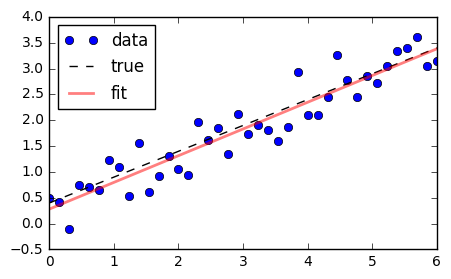

In [17]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, 0.5*X+0.4, '--k', label='true')
plt.plot(X, plinear_model.a.value+plinear_model.b.value*X, '-r', lw=2, alpha=0.5, label='fit')
plt.plot()
plt.legend(loc='best')

# What is inside hb.param.Variable

hb.param.Variable is an object that wraps tf.Variable.  
In fact, `hb.param.Variable._tensor` is tf.Variable

In [18]:
type(linear_fit.a._tensor)

tensorflow.python.ops.variables.Variable

Variable object has `.tensor()` method, that returns the transformed tensor.

In [19]:
print(plinear_model.sigma._tensor) # <- parameters that spans in real space
print(plinear_model.sigma.tensor()) # <- transformed parameters that is cast to the positive space

Tensor("add_8:0", shape=(1,), dtype=float32)


Any parameterized object such as `hb.model.Model` have `.tf_mode()`.  
Within `tf_mode`, Variable object is seen as its .tensor() method.

In [20]:
print('Without tf_mode: '+str(type(plinear_model.a)))
with plinear_model.tf_mode():
    print('With tf_mode: ' + str(type(plinear_model.a)))

Without tf_mode: <class 'Henbun.param.Variable'>
With tf_mode: <class 'tensorflow.python.framework.ops.Tensor'>


In decorated methods by `@hb.model.AutoOptimize()`, 
tf_mode is automatically switched on.

# What is inside @hb.model.AutoOptimize()

The methods decorated by `@hb.model.AutoOptimize()` returns   
`hb.model.Optimizer` object, 
that contains the objective function, variables to be minimized, and so on.

In [21]:
print(type(plinear_model.logp()))

<class 'Henbun.model.Optimizer'>


In [22]:
optimizer = plinear_model.logp()
optimizer.__dict__

{'likelihood_method': <function __main__.LinearModel.logp>,
 'method_op': <tf.Tensor 'add_6:0' shape=(1,) dtype=float32>,
 'model': <__main__.LinearModel at 0x7f3ff80ebb00>,
 'optimize_op': <tensorflow.python.framework.ops.Operation at 0x7f3ff05277b8>}

+ optimizer.likelihood_method is the method to be optimized.
+ optimizer.method_op is a tf.Op that calculates the objective value.  
  In this case, `tf.reduce_sum(log_lik) + log_prior`.
+ optimizer.optimize_op is a tf.Op that handle the optimization.
+ optimizer.model is a reference to the parent model.

Variables to be optimized, what optimizers to be used (such as Adam or AdaGrad) 
can be controlled by `.compile()` method.

The defaults are all the variables and tf.AdamOptimizer().